# Robin Labs Module

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from src.robin.labs.entities import RobinLab

import ipywidgets as widgets
import shutil

path_config_supply = '../configs/supply_data.yml'
path_config_demand = '../configs/demand_data.yml'
tmp_path = '../data/labs/tmp'

In [4]:
step_range = {"min": 0, "max": 10.0, "step": 0.1}
step_widget = widgets.BoundedFloatText(value=10.0, **step_range, description='Step: ')
container = widgets.HBox([step_widget])
display(container)

In [5]:
prices_range = {"min": 0, "max": 500, "step": 1.0}
range_widget = widgets.FloatRangeSlider(value=[0, 350], **prices_range, description='Price increase range: ')
container = widgets.HBox([range_widget])
display(container)

In [6]:
lower_limit, upper_limit = range_widget.value
step = step_widget.value

print(f"Prices increase range: {lower_limit}% - {upper_limit}% with step {step}%")

Prices increase range: 0.0% - 350.0% with step 10.0%


In [7]:
robin_lab = RobinLab(path_config_supply=path_config_supply,
                     path_config_demand=path_config_demand,
                     tmp_path=tmp_path)

In [8]:
config = {"supply": {"start": 0, "stop": 350, "step": 10},
          "demand": (),
          "seed": 53}

robin_lab.set_lab_config(config=config)

  0%|          | 0/35 [00:00<?, ?it/s]

In [9]:
robin_lab.simulate() # Run simulation

  0%|          | 0/35 [00:00<?, ?it/s]

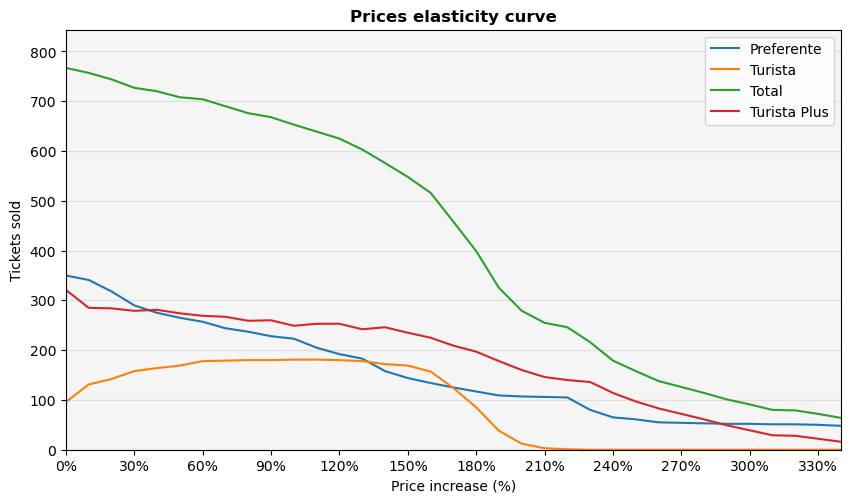

In [28]:
robin_lab.plot_elasticity_curve()

In [3]:
# Remove temporary directory
shutil.rmtree(tmp_path)